<a href="https://colab.research.google.com/github/Venusandjupiter/MachineLearning/blob/main/CNN/ResNet/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!nvidia-smi

Tue Jan 31 15:02:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    51W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import dataloader
import train
import ResNet
import inference
import torch
import torchinfo


Device = 'cuda' if torch.cuda.is_available() else 'cpu'
path = './dataset'
size = 96 #SET IMAGE SHAPE

In [4]:
Block1 = ResNet.Block(in_channels=1,out_channels=64,stride=2,padding=3)
Block2 = ResNet.ResBlock(input_channels=64,out_channels=64,num_residual=2,first_block=True)
Block3 = ResNet.ResBlock(input_channels=64,out_channels=128,num_residual=2)
Block4 = ResNet.ResBlock(input_channels=128,out_channels=256,num_residual=2)
Block5 = ResNet.ResBlock(input_channels=256,out_channels=512,num_residual=2)
Resnet = torch.nn.Sequential(
    Block1,
    *Block2,
    *Block3,
    *Block4,
    *Block5,
    torch.nn.AdaptiveAvgPool2d((1,1)),
    torch.nn.Flatten(),
    torch.nn.Linear(512,10)
)

In [5]:
Resnet.apply(train.init_weights)
torchinfo.summary(Resnet,[1,1,224,224])

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Block: 1-1                             [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         3,200
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─MaxPool2d: 2-3                    [1, 64, 56, 56]           --
├─Residual: 1-2                          [1, 64, 56, 56]           --
│    └─Conv2d: 2-4                       [1, 64, 56, 56]           36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 56, 56]           128
│    └─Conv2d: 2-6                       [1, 64, 56, 56]           36,928
│    └─BatchNorm2d: 2-7                  [1, 64, 56, 56]           128
├─Residual: 1-3                          [1, 64, 56, 56]           --
│    └─Conv2d: 2-8                       [1, 64, 56, 56]           36,928
│    └─BatchNorm2d: 2-9                  [1, 64, 56, 56]           

In [6]:
train_data = dataloader.GetFashionMNIST(path=path,download=True,Resize=96,train=True)
val_data = dataloader.GetFashionMNIST(path=path,download=True,Resize=96,train=False)
train_iter = dataloader.iter_transform(dataset=train_data,batch_size=2048,shuffle=True)
val_iter = dataloader.iter_transform(dataset=val_data,batch_size=2048,shuffle=False)

Running on: NVIDIA A100-SXM4-40GB
=============================epochs:1========================================
train loss:0.826,train acc:73.36%, val_acc:30.09%
=============================epochs:2========================================
train loss:0.309,train acc:88.53%, val_acc:74.42%
=============================epochs:3========================================
train loss:0.235,train acc:91.48%, val_acc:86.93%
=============================epochs:4========================================
train loss:0.201,train acc:92.52%, val_acc:88.71%
=============================epochs:5========================================
train loss:0.170,train acc:93.61%, val_acc:88.87%
=============================epochs:6========================================
train loss:0.141,train acc:94.85%, val_acc:91.01%
=============================epochs:7========================================
train loss:0.112,train acc:95.91%, val_acc:85.96%
=============================epochs:8=================================

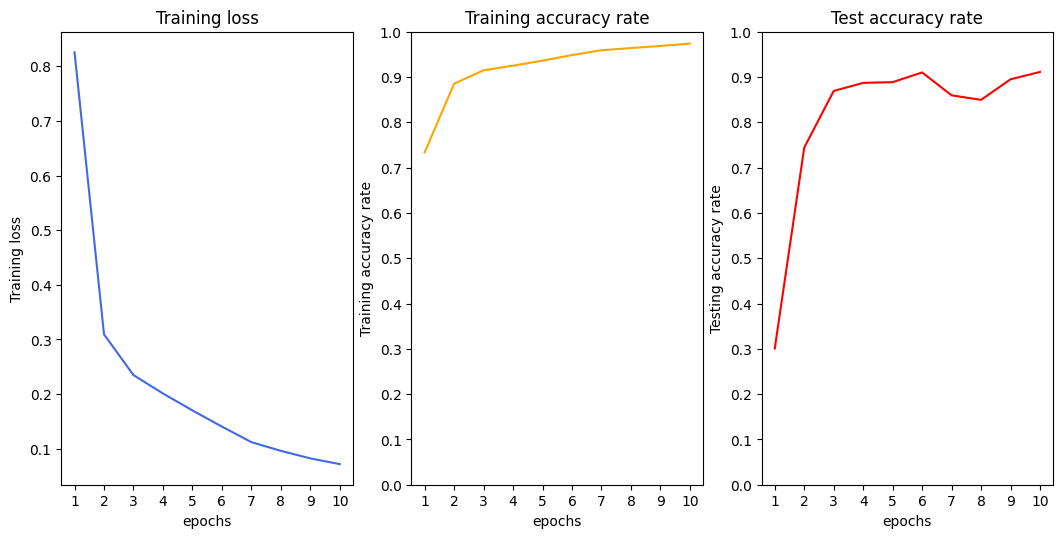

In [7]:
loss_fn = torch.nn.CrossEntropyLoss()
train.train_loop(net = Resnet,loss_fn=loss_fn,num_epochs=10,learning_rate=1e-3,train_iter=train_iter,val_iter=val_iter,device=Device)

accuracy rate:95.0%


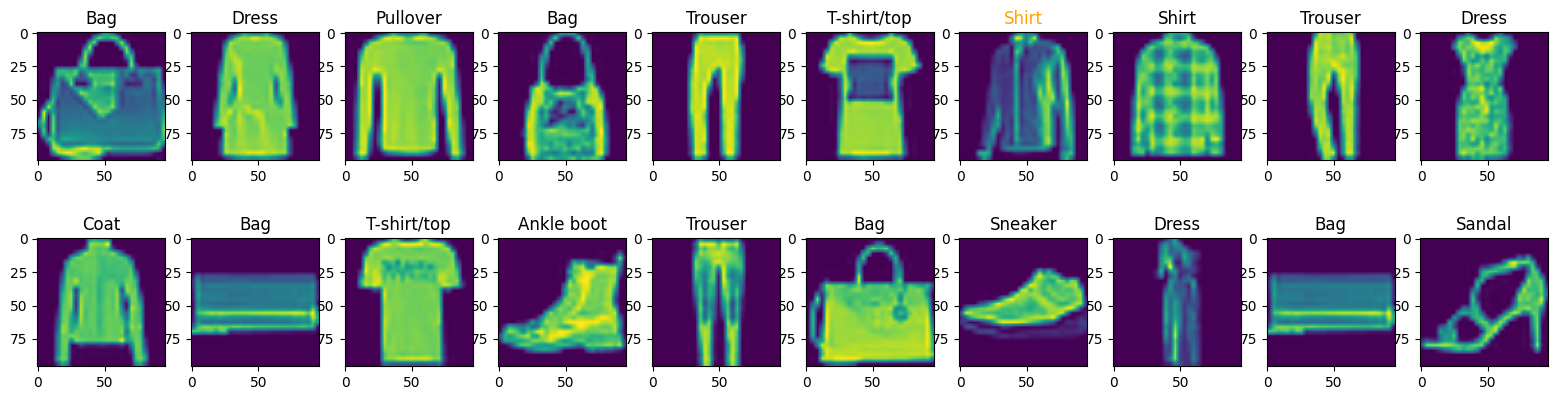

In [10]:
label = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
inference.predict(val_data,Resnet,label)

In [16]:
torch.save(Resnet.state_dict(),'./Resnet.pt')